#### Importing required libraries

In [22]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

#Model Evaluation
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


### Data Loading and Preprocessing

In [23]:
# Defining the paths for the train and test directories
train_dir = '../FER_2013_dataset/train'
test_dir = '../FER_2013_dataset/test'

# Defining the emotion classes based on the folder names
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Function to load and augment images from a directory to balance classes
def load_data_with_augmentation(data_dir, emotion_classes, img_size=(48, 48), target_count=1000,augmentation=True):
    images = []
    labels = []
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for emotion_label, emotion_name in enumerate(emotion_classes):
        emotion_folder = os.path.join(data_dir, emotion_name)
        total_images = 0

        # Load images
        for idx, img_filename in enumerate(os.listdir(emotion_folder)):
            if idx>5000: #skipping sample data
                break
            img_path = os.path.join(emotion_folder, img_filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, img_size)
                img_normalized = img_resized / 255.0
                images.append(img_normalized)
                labels.append(emotion_label)
                total_images += 1

        if(augmentation):
            # Augment if below target count
            if total_images < target_count:
                # Load images in grayscale and add channel dimension for compatibility
                img_data = np.array([cv2.resize(cv2.imread(os.path.join(emotion_folder, img), cv2.IMREAD_GRAYSCALE), img_size) / 255.0 
                                    for img in os.listdir(emotion_folder) if img is not None])

                # Reshape to (images, 48, 48, 1) to add a channel dimension for grayscale
                img_data = np.expand_dims(img_data, axis=-1)
        
                for x in datagen.flow(img_data, batch_size=1):
                    if total_images >= target_count:
                        break
                    images.append(x[0].reshape(img_size))
                    labels.append(emotion_label)
                    total_images += 1
                
    return np.array(images), np.array(labels)


Loading training images from the dataset and assigning each image its corresponding class label.

In [24]:
#Loading training data with augmentation
X_train, y_train= load_data_with_augmentation(train_dir, emotion_classes, target_count=4101,augmentation=True)
# Loading testing data with or without augmentation
X_test, y_test= load_data_with_augmentation(test_dir, emotion_classes, target_count=1000,augmentation=False)


Randomizing the training dataset.

In [25]:
# Zip the lists together and convert to a list of tuples
combined = list(zip(X_train, y_train))

# Shuffle the combined list
random.shuffle(combined)

# Unzip back into separate lists
X_train, y_train = zip(*combined)

# Convert back to lists if needed
X_train_shuffled = np.array(list(X_train))
y_train_shuffled = np.array(list(y_train))

Flattening the training and test data to fit into the model.

In [26]:
# Flattening the training data
X_train_flat = X_train_shuffled.reshape(X_train_shuffled.shape[0], -1)

#Flattening the testing data
X_test_flat = X_test.reshape(X_test.shape[0], -1)

#Printing the shape of all the lists
print("Shape of X_train_shuffled :",X_train_shuffled.shape)
print("Shape of X_train_flat :",X_train_flat.shape)
print("Shape of y_train_shuffled :",y_train_shuffled.shape)
print("Shape of X_test :",X_test.shape)
print("Shape of X_test_flat :",X_test_flat.shape)
print("Shape of y_test :",y_test.shape)

Shape of X_train_shuffled : (31200, 48, 48)
Shape of X_train_flat : (31200, 2304)
Shape of y_train_shuffled : (31200,)
Shape of X_test : (7178, 48, 48)
Shape of X_test_flat : (7178, 2304)
Shape of y_test : (7178,)


In [27]:
#Reinitializing all the variables to ensure consistency in code.
X_train=X_train_flat
y_train=y_train_shuffled
X_test=X_test_flat
y_test=y_test

#--------------------------------------
# Create and train the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=10, random_state=42)

In [28]:
# Calculate training accuracy
training_accuracy = model.score(X_train, y_train)
print(f"Training Accuracy: {training_accuracy * 100:.2f}%")

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Testing Accuracy: {accuracy * 100:.2f}%")


Training Accuracy: 30.60%
Testing Accuracy: 31.69%


  Experiments: 
1.n_estimator:10
  max_depth:5
  Training Accuracy: 30.62%
  Testing Accuracy: 31.86%
2.n_estimator:10
  max_depth:10
  Training Accuracy: 58.71%
  Testing Accuracy: 35.00%
3.n_estimator:10
  max_depth:7
  Training Accuracy: 38.11%
  Testing Accuracy: 33.34%
3.n_estimator:10
  max_depth:15
  Training Accuracy: 90.60%
  Testing Accuracy: 35.14%

In [ ]:
#Calculate cross validation
# cross_val_scores = cross_val_score(model, X_train, y_train, cv=5)
# print("Cross-validation scores:", cross_val_scores)
# print("Average cross-validation score:", cross_val_scores.mean())

Cross-validation scores: [0.28445513 0.28108974 0.2775641  0.2724359  0.28253205]
Average cross-validation score: 0.2796153846153846


In [30]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=emotion_classes))

Classification Report:
              precision    recall  f1-score   support

       angry       0.24      0.02      0.03       958
     disgust       0.02      0.07      0.03       111
        fear       0.30      0.02      0.03      1024
       happy       0.40      0.52      0.46      1774
         sad       0.29      0.32      0.30      1247
    surprise       0.33      0.57      0.41       831
     neutral       0.28      0.36      0.32      1233

    accuracy                           0.32      7178
   macro avg       0.27      0.27      0.23      7178
weighted avg       0.31      0.32      0.28      7178



#### Graph Plotting

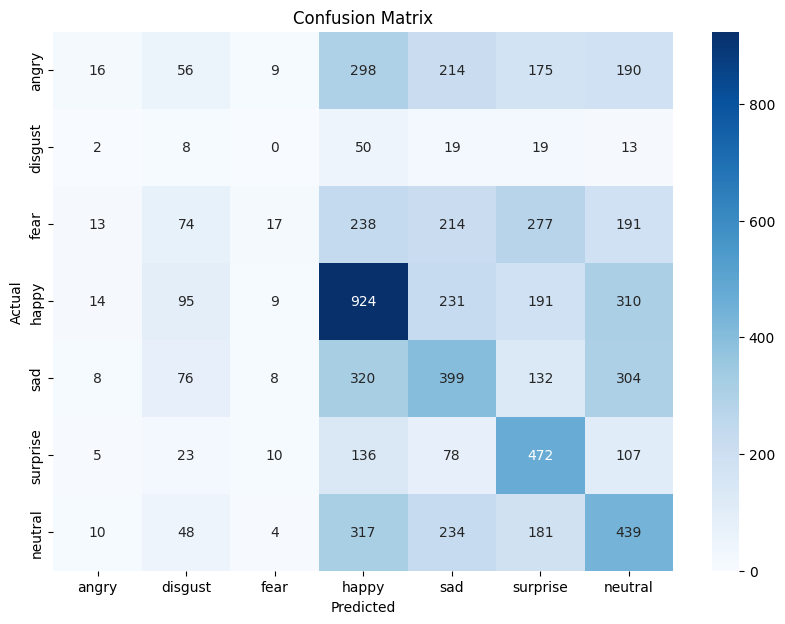

In [31]:
#Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_classes, yticklabels=emotion_classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


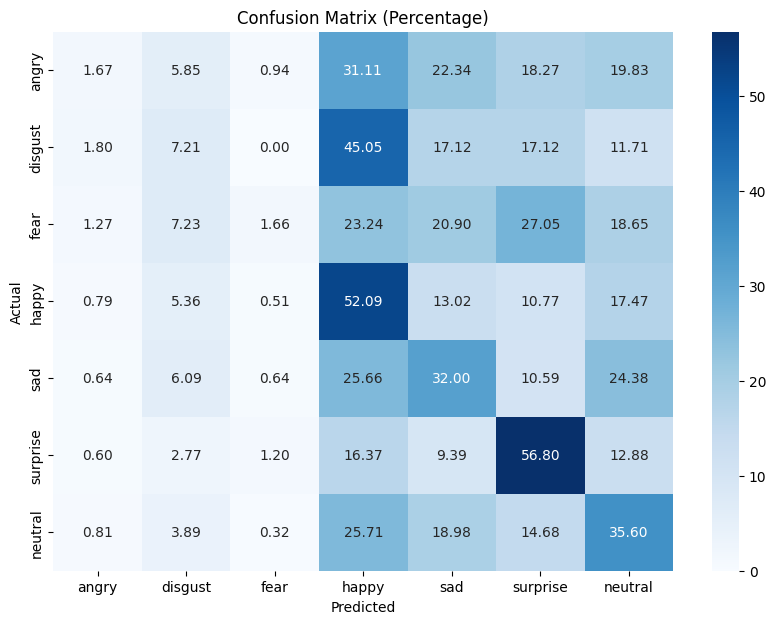

In [32]:
# Normalize the confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix with percentages
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=emotion_classes, yticklabels=emotion_classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()

In [ ]:
#Error confussion matrix 
from sklearn.metrics import ConfusionMatrixDisplay
sample_weight = (y_pred != y_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
sample_weight=sample_weight,display_labels=emotion_classes, normalize="true", 
values_format=".0%")

#### Saving the model section

In [33]:
# Save the SVM model to a file
# import joblib
# joblib.dump(model, 'model_4_svm_rbf_c_100_without_PCA.pkl')

### Applying PCA to the training and test data.

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the flattened training and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Check the new shape after PCA
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)

# Apply PCA
pca = PCA(n_components=25)  # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check the new shape after PCA
print("Shape of X_train_pca:", X_train_pca.shape)
print("Shape of X_test_pca:", X_test_pca.shape)

# You can now train your model on X_train_pca and evaluate it on X_test_pca


Shape of X_train_scaled: (31200, 2304)
Shape of X_test_scaled: (7178, 2304)
Shape of X_train_pca: (31200, 25)
Shape of X_test_pca: (7178, 25)


In [35]:
X_train=X_train_pca
y_train=y_train_shuffled
X_test=X_test_pca
y_test=y_test

#Ready to feed the data to the model
#--------------------------------------
# Create and train the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=10, random_state=42)

In [36]:

# Calculate training accuracy
training_accuracy = model.score(X_train, y_train)
print(f"Training Accuracy: {training_accuracy * 100:.2f}%")

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Testing Accuracy: {accuracy * 100:.2f}%")

Training Accuracy: 29.72%
Testing Accuracy: 29.80%


1.n_estimator:10
  max_depth:5
  Training Accuracy: 29.76%
  Testing Accuracy: 28.96%
2.n_estimator:10
  max_depth:10
  Training Accuracy: 53.20%
  Testing Accuracy: 32.31%
3.n_estimator:10
  max_depth:15
  Training Accuracy: 85.42%
  Testing Accuracy: 35.25%

In [ ]:
#Calculate cross validation
# cross_val_scores = cross_val_score(model, X_train, y_train, cv=5)
# print("Cross-validation scores:", cross_val_scores)
# print("Average cross-validation score:", cross_val_scores.mean())

Cross-validation scores: [0.28060897 0.27451923 0.27596154 0.27788462 0.28942308]
Average cross-validation score: 0.2796794871794872


In [38]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=emotion_classes))

Classification Report:
              precision    recall  f1-score   support

       angry       0.32      0.02      0.04       958
     disgust       0.04      0.21      0.07       111
        fear       0.19      0.01      0.02      1024
       happy       0.41      0.47      0.44      1774
         sad       0.27      0.30      0.28      1247
    surprise       0.32      0.52      0.39       831
     neutral       0.26      0.36      0.30      1233

    accuracy                           0.30      7178
   macro avg       0.26      0.27      0.22      7178
weighted avg       0.30      0.30      0.26      7178



#### Graph Plotting

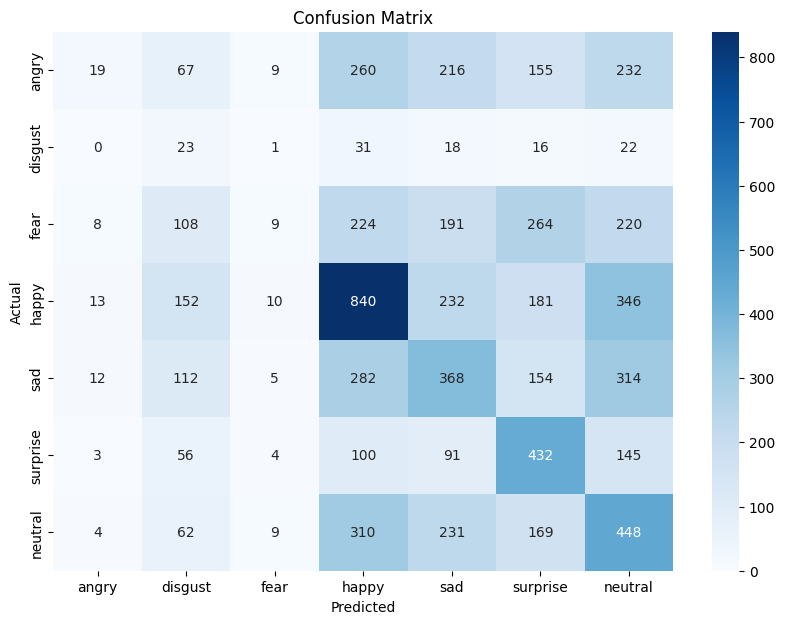

In [39]:
#Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_classes, yticklabels=emotion_classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

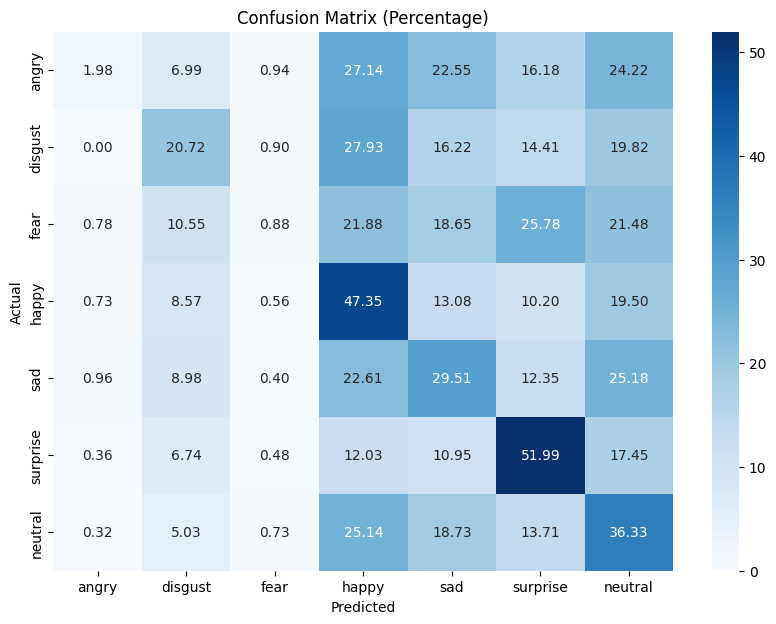

In [40]:
# Normalize the confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix with percentages
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=emotion_classes, yticklabels=emotion_classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()

In [ ]:
#Error confussion matrix 
from sklearn.metrics import ConfusionMatrixDisplay
sample_weight = (y_pred != y_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
sample_weight=sample_weight,display_labels=emotion_classes, normalize="true", 
values_format=".0%")

#### Model Saving Section

In [41]:
# Save the model to a file
# import joblib
# joblib.dump(model, 'model_4_svm_rbf_c_100_with_PCA.pkl') 